# Modelling South Australia's Dec - Mar COVID Outbreak

Due to South Australia's similar dynamics to WA, we try to find pandemix parameters (such as transitivity, latent period, pre symptomatic transmission period) based on the outbreak SA experienced.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [3]:
os.chdir('/Users/Yuval/Desktop/Thesis/COVID-19_data/')

In [4]:
da = pd.read_csv('time_series_covid19_confirmed_global.csv')
da = da.loc[da['Country/Region'] == 'Australia']

In [5]:
states = list(da['Province/State'])
case_numbers = []
for state in states:
    da_temp = da.loc[da['Province/State'] == state]
    da_temp = da_temp.iloc[:,4:]
    case_numbers.append(list(da_temp.iloc[0]))

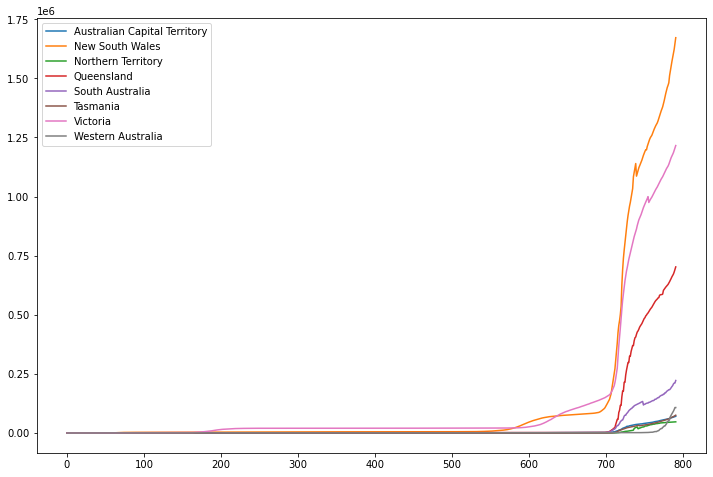

In [6]:
plt.figure(figsize = (12,8))
for c in case_numbers:
    plt.plot(c)
plt.legend(states)

Cool, can remake what Michael did in GetData.jl fairly easily, now let's just look at Adelaide and fit in the compartmental model.

## Adelaide Focus

In [7]:
ad = da.loc[da['Province/State'] == 'South Australia']

In [8]:
ad

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/22,3/15/22,3/16/22,3/17/22,3/18/22,3/19/22,3/20/22,3/21/22,3/22/22,3/23/22
13,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,...,183191,183191,186743,191573,196308,200353,207490,211176,211753,222149


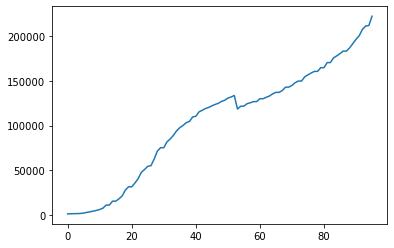

In [9]:
plt.plot(list(ad.iloc[0,700:]))

Omicron reportedly first started in Adelaide on Dec 10th: https://www.sa.gov.au/search?query=omicron&collection=sagov-web-search&x=0&y=0&start_rank=61

Convert the list to number of daily cases

In [10]:
om = ad.iloc[:,691:]
before_om = om.iloc[0,0]
om -= before_om
om

,12/9/21,12/10/21,12/11/21,12/12/21,12/13/21,12/14/21,12/15/21,12/16/21,12/17/21,12/18/21,...,3/14/22,3/15/22,3/16/22,3/17/22,3/18/22,3/19/22,3/20/22,3/21/22,3/22/22,3/23/22
13,0,8,25,38,37,74,98,162,160,233,...,182208,182208,185760,190590,195325,199370,206507,210193,210770,221166


In [11]:
totals = list(om.iloc[0])

daily = []
for i in range(1,len(totals)):
    daily.append(totals[i]-totals[i-1])

In [12]:
SA_health = pd.read_csv('/Users/Yuval/Desktop/Thesis/SA_Health.csv')

In [13]:
sa_total = SA_health.loc[SA_health['Type'] == 'Total']
sa_daily = SA_health.loc[SA_health['Type'] == 'Daily']

In [14]:
om = ad.iloc[:,691:]
before_om = om.iloc[0,0]
om -= before_om
jh = list(om.iloc[0])

In [15]:
om = sa_total.iloc[:,1:]
before_om = om.iloc[0,0]
om -= before_om
saht = list(om.iloc[0])

In [16]:
daily_cases = list(sa_daily.iloc[:,1:].iloc[0])
total_dailys = [0]
for d in daily_cases:
    total_dailys.append(total_dailys[-1] + d)

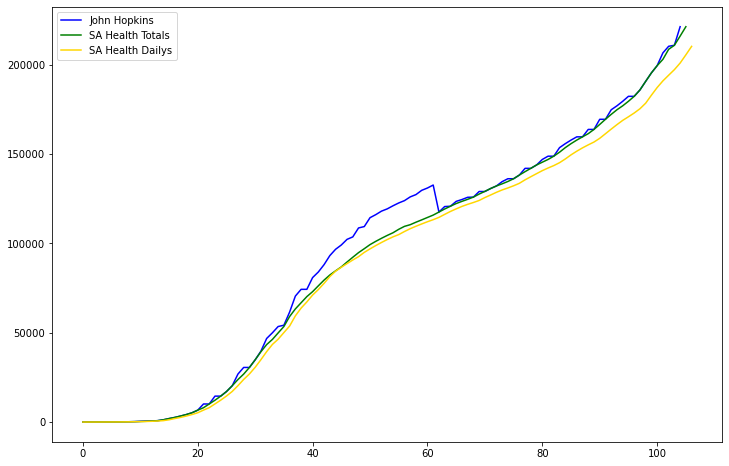

In [17]:
plt.figure(figsize = (12,8))
plt.plot(jh, color = 'blue', label = 'John Hopkins')
plt.plot(saht, color = 'green', label = 'SA Health Totals')
plt.plot(total_dailys, color = 'gold', label = 'SA Health Dailys')
plt.legend()

In [18]:
# Dailys

In [19]:
jh_daily = [0]
for j in range(len(jh)-1):
    jh_daily.append(jh[j+1]-jh[j])

In [20]:
saht_daily = [0]
for j in range(len(saht)-1):
    saht_daily.append(saht[j+1] - saht[j])

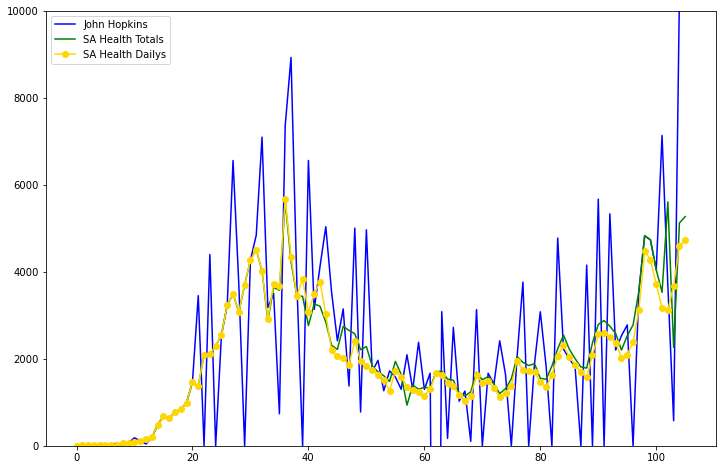

In [21]:
plt.figure(figsize = (12,8))
plt.plot(jh_daily, color = 'blue', label = 'John Hopkins')
plt.plot(saht_daily, color = 'green', label = 'SA Health Totals')
plt.plot(daily_cases,marker = 'o', color = 'gold', label = 'SA Health Dailys')
plt.ylim([0,10000])
plt.legend()

In [22]:
# Five point moving average (for finding inflections)
def moving_average(llist, w_size):
    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []
    
    for j in range(w_size - 1):
        window_average = np.sum(llist[:j+1])/(j+1)
        moving_averages.append(window_average)
        
    while i < len(llist) - w_size + 1:
        window_average = np.sum(llist[i:i+w_size]) / w_size
        moving_averages.append(window_average)
        i += 1
    
    for j in range(w_size - 1):
        window_average = np.sum(llist[len(llist)-w_size+(j+1):])/(j+1)
        

    return moving_averages

In [23]:
ma = moving_average(saht_daily,7)

In [24]:
len(ma) == len(saht_daily)

True

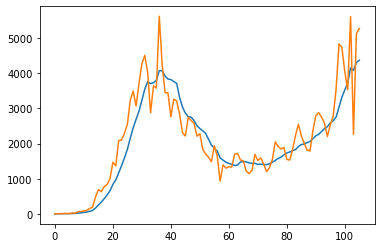

In [25]:
plt.plot(ma)
plt.plot(saht_daily)

In [26]:
ma.index(max(ma[:90]))

36

In [27]:
ma.index(min(ma[40:90]))

62

In [28]:
totals = list(om.iloc[0])

daily = []
for i in range(1,len(totals)):
    daily.append(totals[i]-totals[i-1])

https://www.medrxiv.org/content/10.1101/2022.01.04.22268721v1.full.pdf - this paper claims that latent period is 3 days and infectious period only 2.5 (ie maybe amount of time until they're removed from the population?)

This website https://www1.racgp.org.au/newsgp/clinical/how-does-omicron-compare-with-delta#:~:text=The%20incubation%20period%20of%20Omicron,or%20two%20before%20symptoms%20emerge also claims it's around 3 days, but not sure how solid of a reference it is. It also says the recovery time is around 5 days.

## Adding a Vaccinated Compartment for each dose

In [29]:
sa_vacc = pd.read_csv('/Users/Yuval/Desktop/Thesis/SA_Health_modified.csv')
# South Australia's population is 1.77 million
# 86% of the population is over the age of 12 = 1.5222 million
# 81.3% of the population is over the age of 16 = 1.4337 million
# Hence convert these percentages to numbers of people
sa_vacc.loc[sa_vacc['Type'] == 'First Dose (12+)'] = ['First Dose (12+)'] + list(round(sa_vacc.loc[sa_vacc['Type'] == 'First Dose (12+)'].iloc[:,1:]*1522200/100).iloc[0])
sa_vacc.loc[sa_vacc['Type'] == 'Second Dose (12+)'] = ['Second Dose (12+)'] + list(round(sa_vacc.loc[sa_vacc['Type'] == 'Second Dose (12+)'].iloc[:,1:]*1522200/100).iloc[0])
sa_vacc.loc[sa_vacc['Type'] == 'Third Dose (16+)'] = ['Third Dose (16+)'] + list(round(sa_vacc.loc[sa_vacc['Type'] == 'Third Dose (16+)'].iloc[:,1:]*1433700/100).iloc[0])


In [30]:
sa_vacc.iloc[:,36]

0      54408.0
1       3669.0
2    1418690.0
3    1360847.0
4     295342.0
Name: 13/1/2022, dtype: float64

In [31]:
sa_vacc.iloc[:,75]

0     135548.0
1       1217.0
2    1447612.0
3    1403468.0
4     745524.0
Name: 21/2/2022, dtype: float64

In [32]:
sa_vacc

,Type,9/12/2021,10/12/2021,11/12/2021,12/12/2021,13/12/2021,14/12/2021,15/12/2021,16/12/2021,17/12/2021,...,15/3/2022,16/3/2022,17/3/2022,18/3/2022,19/3/2022,20/3/2022,21/3/2022,22/3/2022,23/3/2022,24/3/2022
0,Total,983.0,991.0,998.0,1008.0,1020.0,1031.0,1057.0,1081.0,1143.0,...,183191.0,186743.0,191573.0,196308.0,200353.0,203881.0,209490.0,211753.0,216878.0,222149.0
1,Daily,0.0,8.0,7.0,10.0,13.0,12.0,25.0,24.0,64.0,...,2380.0,3122.0,4474.0,4274.0,3724.0,3168.0,3121.0,3686.0,4594.0,4742.0
2,First Dose (12+),1380635.0,1383680.0,1385202.0,1386724.0,1386724.0,1388246.0,1391291.0,1392813.0,1394335.0,...,1444568.0,1444568.0,1446090.0,1446090.0,1446090.0,1446090.0,1446090.0,1446090.0,1447612.0,1447612.0
3,Second Dose (12+),1264948.0,1271037.0,1275604.0,1278648.0,1281692.0,1286259.0,1292348.0,1298437.0,1303003.0,...,1404991.0,1406513.0,1408035.0,1408035.0,1409557.0,1409557.0,1409557.0,1411079.0,1411079.0,1411079.0
4,Third Dose (16+),38710.0,44445.0,48746.0,54481.0,58782.0,64516.0,68818.0,73119.0,78854.0,...,854485.0,858786.0,861654.0,865955.0,868822.0,868822.0,873123.0,875991.0,878858.0,881726.0


In [33]:
first = list(sa_vacc.loc[sa_vacc['Type'] == 'First Dose (12+)'].iloc[0])[1:]
first_change = []
for f in range(len(first)-1):
    first_change.append(first[f+1] - first[f])

second = list(sa_vacc.loc[sa_vacc['Type'] == 'Second Dose (12+)'].iloc[0])[1:]
second_change = []
for f in range(len(second)-1):
    second_change.append(second[f+1] - second[f])

third = list(sa_vacc.loc[sa_vacc['Type'] == 'Third Dose (16+)'].iloc[0])[1:]
third_change = []
for f in range(len(third)-1):
    third_change.append(third[f+1] - third[f])

uptakes = [first_change, second_change, third_change]


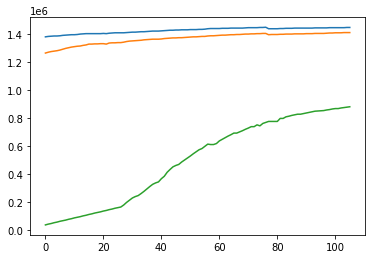

In [34]:
plt.plot(list(sa_vacc.iloc[2,1:]))
plt.plot(list(sa_vacc.iloc[3,1:]))
plt.plot(list(sa_vacc.iloc[4,1:]))

In [35]:
first = list(sa_vacc.iloc[2,1:])
second = list(sa_vacc.iloc[3,1:])

In [36]:
horizontal_gaps = []
for i in range(len(first)):
    f = first [i]
    for j in range(len(second)):
        s = second[j]
        if f == s:
            horizontal_gaps.append(j-i)
np.mean(horizontal_gaps)

66.26881720430107

(array([ 9., 18., 10.,  1.,  0.,  2.,  4.,  7., 25., 17.]),
 array([51. , 53.7, 56.4, 59.1, 61.8, 64.5, 67.2, 69.9, 72.6, 75.3, 78. ]),
 <BarContainer object of 10 artists>)

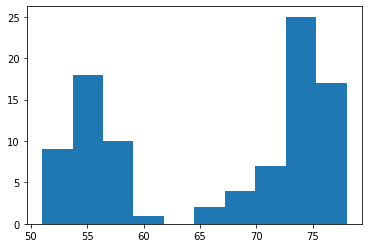

In [37]:
plt.hist(horizontal_gaps)

In [38]:
cases = saht

In [39]:
from scipy.optimize import curve_fit

In [40]:
def sveir(params,x,popn,changes, effic):
    xdot = list(np.zeros(7))
    eff1, eff2, eff3 = effic[0], effic[1], effic[2]
    xdot[0] = -params[0]*x[0]*x[5]/popn - changes[0] # Susceptible
    xdot[1] = -eff1*params[0]*x[1]*x[5]/popn +changes[0] - changes[1]  # First dose
    xdot[2] = -eff2*params[0]*x[2]*x[5]/popn + changes[1] - changes[2] # Second dose
    xdot[3] = -eff3*params[0]*x[3]*x[5]/popn + changes[2] + 1/84*x[6]  # Third dose
    xdot[4] = params[0]*x[0]*x[5]/popn + eff1*params[0]*x[1]*x[5]/popn + eff2*params[0]*x[2]*x[5]/popn + eff3*params[0]*x[3]*x[5]/popn - params[1]*x[4] # Exposed
    xdot[5] = params[1]*x[4] - params[2]*x[5] # Infected
    xdot[6] = params[2]*x[5] - 1/84*x[6] # Removed
    
    infected_daily = params[1]*x[4]
    return xdot, infected_daily

In [41]:
# The big one
def dynamics(x_init,days,steps,a1,a2,a3,uptakes, effic, L, D, inflection_1,inflection_2):
    x = [x_init]
    day_infs = [0]
    
    params = [a1, 1/L, 1/D]
    
    # Iterate over each day
    popul = []
    for day in range(days):
        #Step 1: try the different alphas
        
        if day < inflection_1:
            params[0] = a1
        elif (day>= inflection_1) and (day < inflection_2):
            params[0] = a2
        elif day >=inflection_2:
            params[0] = a3
            
        #print(day,params)
            
        changes = [uptakes[0][day],uptakes[1][day], uptakes[2][day]]
        
        # print(day)
        # Step 2: Use the SEIR equation to simulate the spread over the day.
        infected_daily =[]
        for t in range(steps):
            xdot, infs = sveir(params, x[-1], popn,changes,effic)
            xdot = [i/steps for i in xdot]
            x.append([sum(i) for i in zip(*[x[-1],xdot])])
            popul.append(sum(x[-1]))
            infected_daily.append(infs)
        day_infs.append(sum(infected_daily)/steps+day_infs[-1])
        #print(infected_daily, day_infs[-1])
        
    return x, day_infs, popul

In [42]:
def plotting(y):
    s = list(zip(*y))
    plt.figure(figsize = (6,6))
    plt.plot(s[0],'k', label ='Susceptible')
    plt.plot(s[1],label = 'V1')
    plt.plot(s[2],label = 'V2')
    plt.plot(s[3], label = 'V3')
    plt.plot(s[4],'b', label = 'Exposed')
    plt.plot(s[5],'r', label = 'Infected')
    plt.plot(s[6],'y', label = 'Recovered')
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Number of infected")
    plt.xlim([0,steps*days])
    plt.tight_layout()

In [43]:
effic = [1-0.293, 1-0.126, 1-0.566]
# Set the initial town values (when doing final simulations make sure this is accurate)
popn = 1770000
x_init = [1770000-(1380635+32+8),1380635-1264948,1264948-38710,38710,32,8,0]

# Set number of days for this simulation
days = 105

L = 2.43

inflection_1, inflection_2 = 27,70

# If fitting overall cases
a1, a2,a3, D = 0.95474459, 0.29760718, 0.53051565, 3.7781223

#a1, a2,a3, D =0.80067035, 0.21220242, 0.41161347, 5. 
# If fitting daily cases
#a1, a2,a3, D = 2.21435632, 1.27734592, 1.92716264, 1.

params = [a1, 1/L, 1/D]

steps = 5

# Call the function (just once)
y, day_infs, popul = dynamics(x_init,days,steps,a1,a2,a3,uptakes,effic, L, D,inflection_1,inflection_2)

In [50]:
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

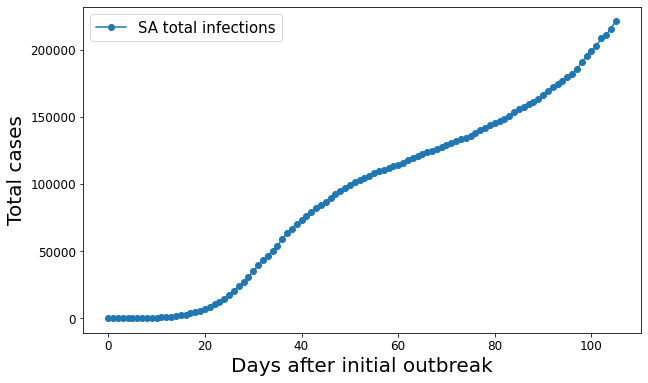

In [51]:
plt.figure(figsize = (10,6))
plt.plot(saht, marker = 'o', label = 'SA total infections')
#plt.plot(day_infs, label = 'Simulation Results')
plt.ylabel('Total cases', size = 20)
plt.xlabel('Days after initial outbreak', size = 20)
plt.legend(fontsize = 15)
#plt.title('South Australia Omicron Outbreak', size =20)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


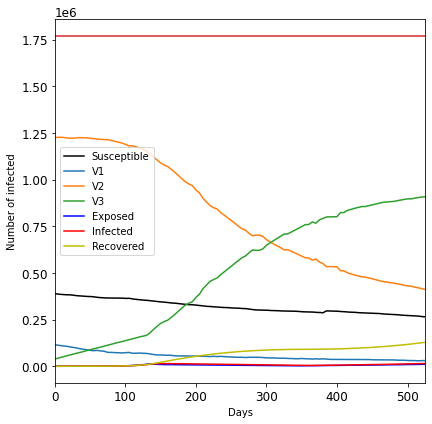

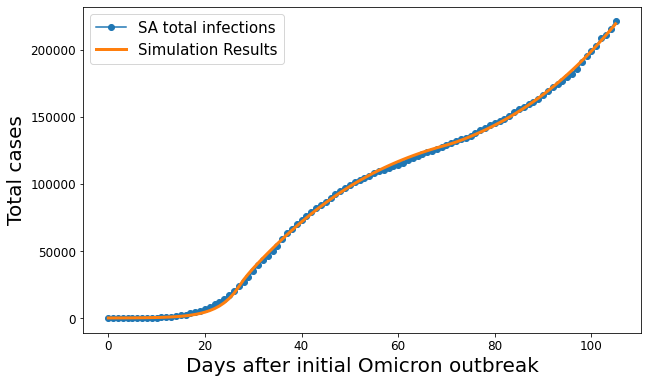

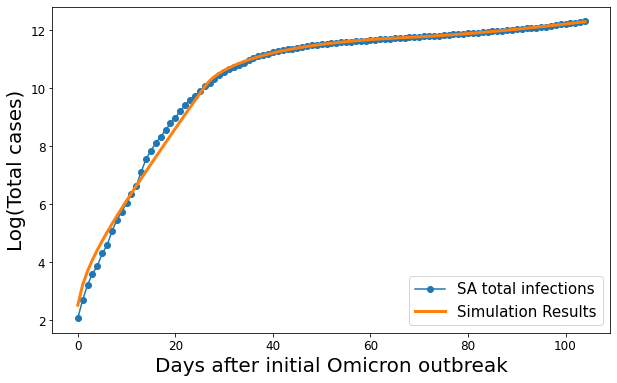

In [78]:
plotting(y)
plt.plot(popul)
plt.figure(figsize = (10,6))
#x = [i/5 for i in range(5*105)]
#plt.plot(x,datt)
plt.plot(saht, marker = 'o', label = 'SA total infections')
plt.plot(day_infs, label = 'Simulation Results', linewidth = 3)
plt.ylabel('Total cases', size = 20)
plt.xlabel('Days after initial Omicron outbreak', size = 20)
plt.legend(fontsize = 15)
#plt.title('Using Adelaide\'s outbreak to of best fit parameters', size =20)
plt.figure(figsize = (10,6))
#x = [i/5 for i in range(5*105)]
#plt.plot(x,datt)
plt.plot(list(np.log(saht))[1:], marker = 'o', label = 'SA total infections')
plt.plot(list(np.log(day_infs))[1:], label = 'Simulation Results', linewidth = 3)
plt.ylabel('Log(Total cases)', size = 20)
plt.xlabel('Days after initial Omicron outbreak', size = 20)
plt.legend(fontsize = 15)
#plt.title('Using Adelaide\'s outbreak to of best fit parameters', size =20)

In [54]:
daily_infs = [0]
for i in range(1,len(day_infs)):
    daily_infs.append(day_infs[i]- day_infs[i-1])

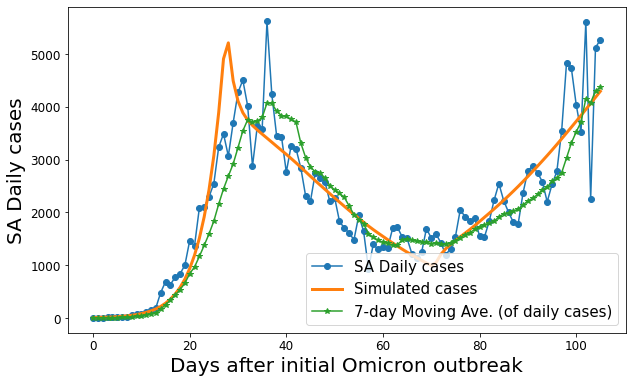

In [61]:
plt.figure(figsize = (10,6))
plt.plot(saht_daily, marker = 'o', label = 'SA Daily cases')
plt.plot(daily_infs, label = 'Simulated cases',linewidth = 3)
plt.plot(ma, marker = '*', label = '7-day Moving Ave. (of daily cases)')
plt.xlabel('Days after initial Omicron outbreak', size = 20)
plt.ylabel('SA Daily cases', size = 20)
plt.legend(fontsize = 15, loc = 'lower right')

Have decided to set L=2.43 for now because this paper (https://academic.oup.com/cid/advancearticle/doi/10.1093/cid/ciab746/6359063fbclid=IwAR2CVp4AJAKuwMINxcVlpATDsBWW4StKerqlGYlMwwd5jqOFDaBsaKbmAWg&login=false) has stated that they estimated latent period to be 5.5 days and incubation period to be 6.9 days. However, this is pre-omicron figures. The WHO report Shannon sent says incubation period is about 2.9 to 3.2, so taking 5.5/6.9*3.05 = 2.43

In [106]:
def func(x, a1, a2, a3,D):
    y, day_infs, popul = dynamics(x_init,days,steps,a1,a2,a3,uptakes,effic, L, D,inflection_1,inflection_2)
    #return list(np.log(day_infs))[1:] # if fitting log cases
    # If fitting daily cases
    #daily_infs = [0]
    #for i in range(1,len(day_infs)):
    #    daily_infs.append(day_infs[i]- day_infs[i-1])
    #return list(daily_infs)[:]
    return list(day_infs)[1:]

In [107]:
x = [i for i in range(1,len(cases))]
#y = list(np.log(cases))[1:]
y = list(cases)[1:]
#y = ma # if fitting daily cases

popt, pcov = curve_fit(func, x, y,bounds = ([0.1,0.1,0.1,1],[3,3,3,7]))

In [108]:
popt

array([0.95474459, 0.29760718, 0.53051565, 3.7781223 ])

In [109]:
pcov

array([[ 0.00053029,  0.00040144,  0.00065055, -0.00478582],
       [ 0.00040144,  0.00030585,  0.00049145, -0.00363297],
       [ 0.00065055,  0.00049145,  0.00080047, -0.00586728],
       [-0.00478582, -0.00363297, -0.00586728,  0.04324483]])

In [110]:
perr = np.sqrt(np.diag(pcov))
perr *=2
perr

array([0.04605607, 0.03497691, 0.05658512, 0.41590783])

In [111]:
# 95% CI
parnames = ['del_1','del_2', 'del_3', 'D']
print("{:5s}  {:5s}  {:5s}  {:5s}".format('Par','Val','LB','UB'))
for i in range(4):
    print("{:5s}  {:.3f}  {:.3f}  {:.3f}".format(parnames[i], round(popt[i],3), round(popt[i]-perr[i],3), 
                                           round(popt[i] +perr[i],3)))

Par    Val    LB     UB   
del_1  0.955  0.909  1.001
del_2  0.298  0.263  0.333
del_3  0.531  0.474  0.587
D      3.778  3.362  4.194


In [116]:
# Find R_0
dels = [0.95474459, 0.29760718, 0.53051565]
inf_pts = [0,27,70]

for j in range(3):
    i = inf_pts[j]
    de = dels[j]
    cu = y[i*steps]
    smc = sum(cu)
    eff_delta = cu[0]/smc*de + effic[0]*cu[1]/smc*de + effic[1]*cu[2]/smc*de + effic[2]*cu[3]/smc*de
    R0 = eff_delta * sum(cu[0:4])/smc / (1/3.778)
    print(i,R0)

0 3.178283495356121
27 0.9142821409339759
70 1.2434694797607697


## Checking best combination of inflection points in days

In [90]:
inf_1s = [20+i for i in range(20)]
inf_2s = [60+i for i in range(20)]

goodness = []

for item in inf_2s:
    
    inflection_1 = 27
    inflection_2 = item
    x = [i for i in range(1,len(cases))]
    #y = list(np.log(cases))[1:]
    y = list(cases)[1:]
    #y = ma # if fitting daily cases

    popt, pcov = curve_fit(func, x, y,bounds = ([0.1,0.1,0.1,1],[3,3,3,7]))
    
    goodness.append(sum(np.sqrt(np.diag(pcov))))
    
    print(item)

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


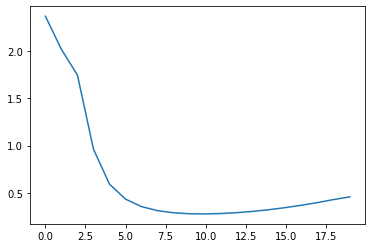

In [91]:
plt.plot(goodness)

In [92]:
goodness.index(min(goodness))

10

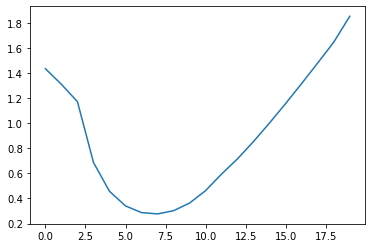

In [88]:
plt.plot(goodness)

In [89]:
goodness.index(min(goodness))

7